In [2]:
# Preliminary data notebook for
# NIH: Imaging Guided Intervention Surgery Study Section

# Exploratory aim: evaluate presurgical scans between STN and GPi targets
#   Given retrospective GPi acquisitions?
#   Search for radiomic differentiators for STN versus GPi selection in presurgical scans

In [3]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
from sklearn.linear_model import QuantileRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor

In [4]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [5]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
visualize = 1
# Load data
nrows = 256
ncols = 256
nslices = 160
segs = []
qsms = []
laros = []
voxel_sizes = []
trackers = []
q_directory = '/media/mts_dbs/ChanghaiDBS_QSM/nii/qsm/'
q_directory = os.listdir(q_directory)
q_directory = sorted(q_directory)
qu_directory = '/media/mts_dbs/ChanghaiDBS_QSM/nii/laro/'
qu_directory = os.listdir(qu_directory)
qu_directory = sorted(qu_directory)
s_directory = '/media/mts_dbs/ChanghaiDBS_QSM/nii/roi/'
s_directory = os.listdir(s_directory)
s_directory = sorted(s_directory)
m_directory = '/media/mts_dbs/ChanghaiDBS_QSM/nii/mask/'
m_directory = os.listdir(m_directory)
m_directory = sorted(m_directory)
case_list = []
d_count = 0
if visualize == 1:
    for filename in q_directory:
    
        seg_filename = s_directory[d_count]
        laro_filename = qu_directory[d_count]
        mask_filename = m_directory[d_count]
        seg = nib.load('/media/mts_dbs/ChanghaiDBS_QSM/nii/roi/'+seg_filename)
        mask = nib.load('/media/mts_dbs/ChanghaiDBS_QSM/nii/mask/'+mask_filename)
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata()[:nrows,:ncols,:nslices])
        qsm = nib.load('/media/mts_dbs/ChanghaiDBS_QSM/nii/qsm/'+filename)
        qsms.append(qsm.get_fdata()[:nrows,:ncols,:nslices])

        laro = nib.load('/media/mts_dbs/ChanghaiDBS_QSM/nii/laro/'+laro_filename)
        laros.append(1000*laro.get_fdata()[:nrows,:ncols,:nslices])
        print('Appending arrays with segmentation',seg_filename,'QSM,',filename,
              'LARO,',laro_filename,'and mask',mask_filename)
        case_list.append(filename)
        n_cases = len(segs)
        d_count = d_count+1

        qsms_wl = np.asarray(qsms)
        laros_wl = np.asarray(laros)
        segs_wl = np.asarray(segs)



Appending arrays with segmentation 01_roi_combined.nii QSM, 00001_qsm.nii.gz LARO, QSM_lr_01.nii and mask mask01.nii
Appending arrays with segmentation 02_roi_combined.nii QSM, 00002_qsm.nii.gz LARO, QSM_lr_02.nii and mask mask02.nii
Appending arrays with segmentation 03_roi_combined.nii QSM, 00003_qsm.nii.gz LARO, QSM_lr_03.nii and mask mask03.nii
Appending arrays with segmentation 04_roi_combined.nii QSM, 00004_qsm.nii.gz LARO, QSM_lr_04.nii and mask mask04.nii
Appending arrays with segmentation 05_roi_combined.nii QSM, 00005_qsm.nii.gz LARO, QSM_lr_05.nii and mask mask05.nii
Appending arrays with segmentation 06_roi_combined.nii QSM, 00006_qsm.nii.gz LARO, QSM_lr_06.nii and mask mask06.nii


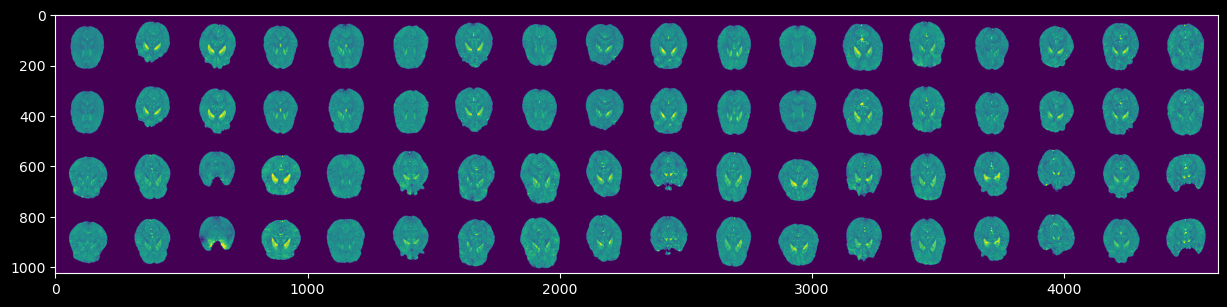

In [ ]:
if visualize == 1:
    qsms_wl[qsms_wl < m1] = m1
    qsms_wl[qsms_wl > m2] = m2
    laros_wl[laros_wl < m1] = m1
    laros_wl[laros_wl > m2] = m2
    multi_slice_viewer(np.hstack(((np.vstack(qsms_wl[:n_cases//2,:,:,:]/1000+0*segs_wl[:n_cases//2,:,:,:]).T),
                                  (np.vstack(laros_wl[:n_cases//2,:,:,:]/1000+0*segs_wl[:n_cases//2,:,:,:]).T),
                                  (np.vstack(qsms_wl[(n_cases-n_cases//2):,:,:,:]/1000+0*segs_wl[(n_cases-n_cases//2):,:,:,:]).T),
                                  (np.vstack(laros_wl[(n_cases-n_cases//2):,:,:,:]/1000+0*segs_wl[(n_cases-n_cases//2):,:,:,:]).T))))
                                    
    label_min = np.partition(np.unique(seg.get_fdata().ravel()), 1)[1]
    label_max = np.amax(seg.get_fdata())

In [ ]:
df = pd.read_csv("/media/mts_dbs/ChanghaiDBS_QSM/xlsx/updrs_iii_chh.csv")
df

,subjects,LCT,Unnamed: 2,UPDRSⅢ,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NaN,NaN,NaN,Preoperative Off-Medicine,Preoperative On-Medicine,Postoperative Off-Medicine &Off-Stimulation\n,Postoperative Off-Medicine &On-Stimulation,Postoperative On-Medicine &On-Stimulation,NaN
1,1.0,62.26%,NaN,53,20,40,15,7,NaN
2,2.0,75.00%,NaN,32,8,26,17,10,NaN
3,3.0,51.72%,NaN,58,28,52,18,20,NaN
4,4.0,22.58%,NaN,62,48,61,36,28,NaN
5,5.0,55.88%,NaN,34,15,44,29,22,NaN
6,6.0,75.44%,NaN,57,14,55,32,16,NaN
7,7.0,84.00%,NaN,100,16,68,12,NaN,NaN
8,8.0,41.86%,NaN,43,25,48,26,26,NaN
9,9.0,72.58%,NaN,62,17,56,25,11,NaN


In [ ]:
# Patient IDs
subject_id = np.asarray(df[df.columns[0]])[1:]

# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
case_number = np.zeros_like(np.asarray(s_directory))
for i in range(n_cases):
    case_number[i] = float(s_directory[i][:2])
subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
for i in range(n_cases):
    try:
        print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
    except:
        print('Case',subject_id[i],'quarantined')






Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 01_roi_combined.nii for case 1.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 02_roi_combined.nii for case 2.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 03_roi_combined.nii for case 3.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 04_roi_combined.nii for case 4.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 05_roi_combined.nii for case 5.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 06_roi_combined.nii for case 6.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 07_roi_combined.nii for case 7.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 08_roi_combined.nii for case 8.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 09_roi_combined.nii for case 9.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 10_roi_combined.nii for case 10.0
Found ROIs [0. 1. 2

In [ ]:
pre_updrs_iii_off =  np.asarray(df[df.columns[3]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])                                
pre_updrs_iii_on =  np.asarray(df[df.columns[4]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])
post_updrs_iii_off =  np.asarray(df[df.columns[6]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])

per_change = (np.asarray(pre_updrs_iii_off).astype(float)-np.asarray(post_updrs_iii_off).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))
lct_change = (np.asarray(pre_updrs_iii_off).astype(float)-(np.asarray(pre_updrs_iii_on)).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))

In [ ]:
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

reextract = 0

# Assume all voxel sizes are identical
voxel_size = (0.9,0.9,0.9)
if reextract == 1:
    # Generate feature structure Phi from all ROIs and all cases
    extractor = featureextractor.RadiomicsFeatureExtractor()
    extractor.enableAllFeatures()
    extractor.enableAllImageTypes()
    extractor.enableFeatureClassByName('shape2D',enabled = False)

    seg_labels_all = np.unique(np.asarray(segs))
    Phi_gt = []
    Phi_vd = []
    Phi_lr = []
    seg_labels = []
    reextract = 0
    x_row_gt = []
    x_row_lr = []

    keylib = []
    roilib = []
    loop_count = 1
    n_rois = seg_labels_all[seg_labels_all>0].__len__()
    roi_names = np.asarray(['Background','Right substantia nigra','Right subthalamic nucleus',
                            'Left subthalamic nucleus', 'Left substantia nigra', 'Right dentate nucleus', 'Left dentate nucleus'])
    for i in np.arange(subject_id_corr.__len__()):
        seg_sitk = sitk.GetImageFromArray(segs[i])
        seg_sitk.SetSpacing(voxel_size)
        qsm_sitk_gt = sitk.GetImageFromArray(qsms[i])
        qsm_sitk_gt.SetSpacing(voxel_size)
        qsm_sitk_lr = sitk.GetImageFromArray(laros[i])
        qsm_sitk_lr.SetSpacing(voxel_size)
        # Index back since subject 12 is missing ROIs
        for j in seg_labels_all:
            if j>0:
                fv_count = 0
                featureVector_gt = extractor.execute(qsm_sitk_gt,seg_sitk,label=int(j));
                featureVector_lr = extractor.execute(qsm_sitk_lr,seg_sitk,label=int(j));
                Phi_gt.append(featureVector_gt)
                Phi_lr.append(featureVector_lr)
                for key, value in six.iteritems(featureVector_gt):
                    if 'diagnostic' in key:
                        next
                    else:
                        x_row_gt.append(featureVector_gt[key])
                        x_row_lr.append(featureVector_lr[key])
                        fv_count = fv_count+1
                        keylib.append(key)
                        roilib.append(roi_names[int(j)])
                x_row_gt.append(pre_updrs_iii_off[i])
                x_row_lr.append(pre_updrs_iii_off[i])
                fv_count = fv_count+1
        print('Extracting features for subject',subject_id_corr[i],'and appending feature matrix with vector of length',fv_count,'with UPDRS score',pre_updrs_iii_off[i])
                
    X0_gt = np.array(x_row_gt)
    X0_lr = np.array(x_row_lr)
    np.save('./npy/X0_gt_chh_rois.npy',X0_gt)
    np.save('./npy/X0_lr_chh_rois.npy',X0_lr)

    K = np.asarray(keylib)
    R = np.asarray(roi_names)
    np.save('./npy/K_chh.npy',K)
    np.save('./npy/R_chh.npy',R)

    print('Saving ground truth feature vector')
    with open('./phi/Phi_mcl_gt_roi_chh', 'wb') as fp:  
        pickle.dump(Phi_gt, fp)
    
    print('Saving undersampled feature vector')
    with open('./phi/Phi_mcl_lr_roi_chh', 'wb') as fp:  
        pickle.dump(Phi_lr, fp)

else:
    X0_gt = np.load('./npy/X0_gt_chh_rois.npy')
    X0_lr = np.load('./npy/X0_lr_chh_rois.npy')
    K = np.load('./npy/K_chh.npy')
    R = np.load('./npy/R_chh.npy')
    n_rois = R.shape[0]-1
    with open('./phi/Phi_mcl_gt_roi_chh', "rb") as fp:  
        Phi_gt = pickle.load(fp)
    
    with open('./phi/Phi_mcl_lr_roi_chh', "rb") as fp:  
        Phi_lr = pickle.load(fp)

    

Extracting features for subject 1.0 and appending feature matrix with vector of length 1596 with UPDRS score 53
Extracting features for subject 2.0 and appending feature matrix with vector of length 1596 with UPDRS score 32
Extracting features for subject 3.0 and appending feature matrix with vector of length 1596 with UPDRS score 58
Extracting features for subject 4.0 and appending feature matrix with vector of length 1596 with UPDRS score 62
Extracting features for subject 5.0 and appending feature matrix with vector of length 1596 with UPDRS score 34
Extracting features for subject 6.0 and appending feature matrix with vector of length 1596 with UPDRS score 57
Extracting features for subject 7.0 and appending feature matrix with vector of length 1596 with UPDRS score 100
Extracting features for subject 8.0 and appending feature matrix with vector of length 1596 with UPDRS score 43
Extracting features for subject 9.0 and appending feature matrix with vector of length 1596 with UPDRS 

In [ ]:
n_cases = len(per_change)
n_roisc = Phi_gt.__len__()/n_cases
L = int(len(X0_gt)/n_cases)
n_features = int(L/n_rois)

In [ ]:
n_features

1596

In [ ]:
x_row_gt = X0_gt.tolist()
X = np.zeros((n_cases,n_rois,n_features)).transpose((0,2,1))
X = X0_gt.reshape((n_cases,n_rois,n_features)).transpose((0,2,1))
X_lr = X0_lr.reshape((n_cases,n_rois,n_features)).transpose((0,2,1))
ut_ls = np.zeros((subject_id_corr.__len__()))
ut_qr = np.zeros((subject_id_corr.__len__()))
ut_qrlr = np.zeros((subject_id_corr.__len__()))
ut_lr = np.zeros((subject_id_corr.__len__()))
ut_en = np.zeros((subject_id_corr.__len__()))
# Normalize testing and training cases together
#   Set with_mean=False to preserve data sparsity
#   And with_std=False 
#   However, need a significant number of samples to do this
X_all = X.reshape(n_cases,((n_features)*n_rois))
X_all_lr = X_lr.reshape(n_cases,((n_features)*n_rois))
scaler = StandardScaler()
X_all_t = scaler.fit_transform(X_all)
X_all_t_lr = scaler.fit_transform(X_all_lr)
C = np.zeros_like(X_all_t)
for j in np.arange(len(subject_id_corr)):
        # Add UPDRS after scaling
        # Might be overwriting a feature here
        X_all_t[j,-1] = pre_updrs_iii_off[int(j)]
        X_all_t_lr[j,-1] = pre_updrs_iii_off[int(j)]
        X_in = X_all_t
        X_in_lr = X_all_t_lr
        X_in = np.delete(X_in,j,axis=0)
        X_in_lr = np.delete(X_in_lr,j,axis=0)
        p_per_change = per_change
        per_change_in = np.delete(p_per_change,j,axis=0)
        # Cross-validation for model selection
        #cv = KFold(np.sum(subject_id_corr < N_train+1)-1//2)
        #print('Kfold complete')
        # Identify most important features
        clf_ls = Lasso(alpha=1e-4,max_iter=10000).fit(X_in,per_change_in)
        clf_lr = Lasso(alpha=1e-4,max_iter=10000).fit(X_in_lr,per_change_in)
        #clr_rr = RANSACRegressor().fit(X_in,per_change_in)
        clf_qr = QuantileRegressor(quantile=0.25, alpha=1e-2).fit(X_in,per_change_in)
        clf_qrlr = QuantileRegressor(quantile=0.25, alpha=1e-2).fit(X_in_lr,per_change_in)
        clf_en = ElasticNet(alpha=1e-4,max_iter=10000,l1_ratio=0.1).fit(X_in,per_change_in)
        #LassoCV(cv=cv,verbose=1,n_jobs=-1,max_iter=10000).fit(X_in,per_change_in)
        #print('Cross validation complete')
        #print('Grid search complete')
        print('Fit complete')
        
        ut_ls[j] = clf_ls.predict(X_all_t[j,:].reshape(1, -1))
        C[j] = clf_ls.coef_


        ut_lr[j] = clf_lr.predict(X_all_t_lr[j,:].reshape(1, -1))
        ut_qr[j] = clf_qr.predict(X_all_t[j,:].reshape(1, -1))
        # ut_qrlr[j] = clf_qrlr.predict(X_all_t_lr[j,:].reshape(1, -1))
        ut_en[j] = clf_en.predict(X_all_t[j,:].reshape(1, -1))
        #print('Fully-sampled predicted percentage change of',ut_qr[j],'and under-sampled predicted',ut_qrlr[j],'for case',j)
        #print('True percentage change',per_change[j])
        #print('Selected alpha:',clf_ls.alpha_)
        print('Patient ID',str(subject_id_corr[j]),'with pre-surgical UPDRS score',str(pre_updrs_iii_off[int(j)]),'at feature matrix row',str(j))


Fit complete
Patient ID 1.0 with pre-surgical UPDRS score 53 at feature matrix row 0
Fit complete
Patient ID 2.0 with pre-surgical UPDRS score 32 at feature matrix row 1
Fit complete
Patient ID 3.0 with pre-surgical UPDRS score 58 at feature matrix row 2
Fit complete
Patient ID 4.0 with pre-surgical UPDRS score 62 at feature matrix row 3
Fit complete
Patient ID 5.0 with pre-surgical UPDRS score 34 at feature matrix row 4
Fit complete
Patient ID 6.0 with pre-surgical UPDRS score 57 at feature matrix row 5
Fit complete
Patient ID 7.0 with pre-surgical UPDRS score 100 at feature matrix row 6
Fit complete
Patient ID 8.0 with pre-surgical UPDRS score 43 at feature matrix row 7
Fit complete
Patient ID 9.0 with pre-surgical UPDRS score 62 at feature matrix row 8
Fit complete
Patient ID 10.0 with pre-surgical UPDRS score 64 at feature matrix row 9
Fit complete
Patient ID 11.0 with pre-surgical UPDRS score 94 at feature matrix row 10
Fit complete
Patient ID 13.0 with pre-surgical UPDRS score 67

<function matplotlib.pyplot.show(*args, **kw)>

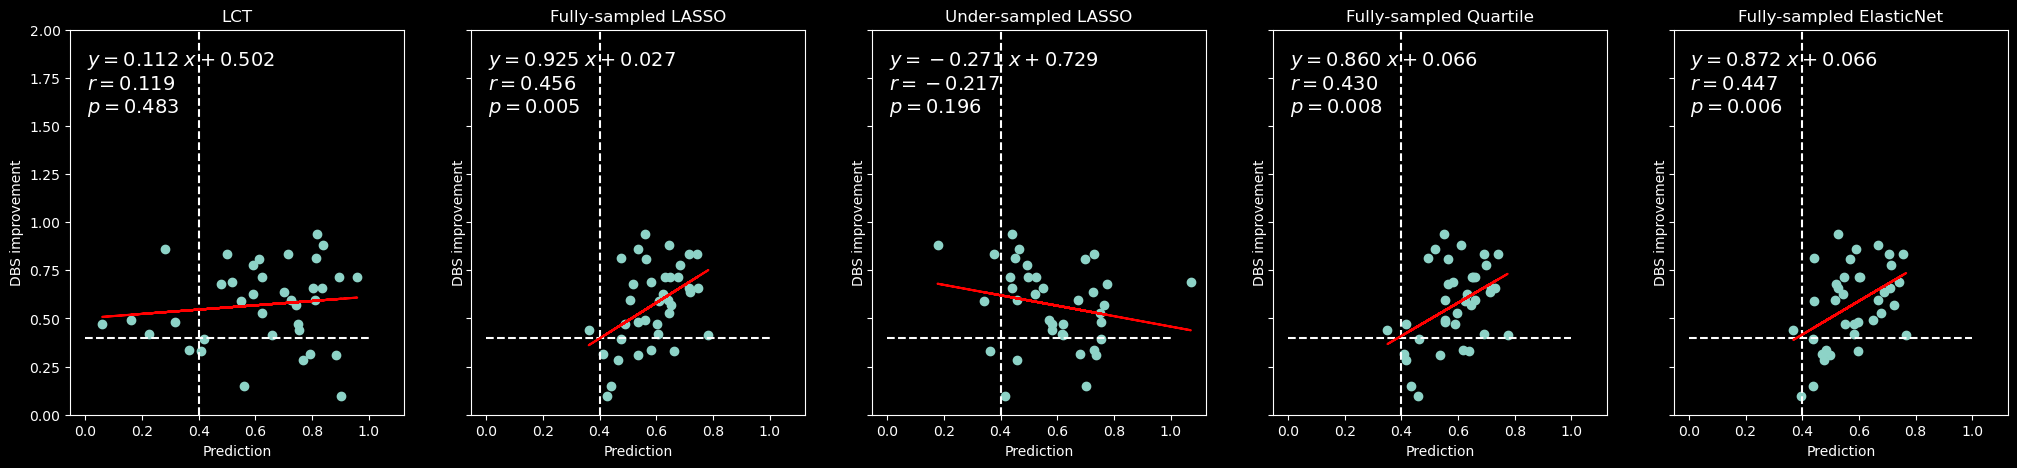

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (25,5)
# Cross validation results
[fig,ax] = plt.subplots(1,5,sharex=True, sharey=True)
lr_prepost = linregress(lct_change,per_change)
ax[0].scatter(lct_change,per_change,)
ax[0].plot(lct_change,lct_change*lr_prepost.slope+lr_prepost.intercept,'-r')
ax[0].set_title('LCT')
ax[0].set_ylabel("DBS improvement")
ax[0].set_xlabel("Prediction")
ax[0].set_ylim([0, 2])
text = f"$y={lr_prepost.slope:0.3f}\;x{lr_prepost.intercept:+0.3f}$\n$r = {lr_prepost.rvalue:0.3f}$\n$p = {lr_prepost.pvalue:0.3f}$"
ax[0].text(0.05, 0.95, text,transform=ax[0].transAxes,
     fontsize=14, verticalalignment='top')
ax[0].hlines(0.4,0,1,linestyle='dashed',color='white')
ax[0].vlines(0.4,0,2,linestyle='dashed',color='white')

lr_pred_ls = linregress(ut_ls,per_change)
ax[1].scatter(ut_ls,per_change)
ax[1].plot(ut_ls,ut_ls*lr_pred_ls.slope+lr_pred_ls.intercept,'-r')
ax[1].set_title('Fully-sampled LASSO')
ax[1].set_ylabel("DBS improvement")
ax[1].set_xlabel("Prediction")
text = f"$y={lr_pred_ls.slope:0.3f}\;x{lr_pred_ls.intercept:+0.3f}$\n$r = {lr_pred_ls.rvalue:0.3f}$\n$p = {lr_pred_ls.pvalue:0.3f}$"
ax[1].text(0.05, 0.95, text,transform=ax[1].transAxes,
     fontsize=14, verticalalignment='top')
ax[1].hlines(0.4,0,1,linestyle='dashed',color='white')
ax[1].vlines(0.4,0,2,linestyle='dashed',color='white')

lr_pred_lr = linregress(ut_lr,per_change)
ax[2].scatter(ut_lr,per_change)
ax[2].plot(ut_lr,ut_lr*lr_pred_lr.slope+lr_pred_lr.intercept,'-r')
ax[2].set_title('Under-sampled LASSO')
ax[2].set_ylabel("DBS improvement")
ax[2].set_xlabel("Prediction")
text = f"$y={lr_pred_lr.slope:0.3f}\;x{lr_pred_lr.intercept:+0.3f}$\n$r = {lr_pred_lr.rvalue:0.3f}$\n$p = {lr_pred_lr.pvalue:0.3f}$"
ax[2].text(0.05, 0.95, text,transform=ax[2].transAxes,
     fontsize=14, verticalalignment='top')
ax[2].hlines(0.4,0,1,linestyle='dashed',color='white')
ax[2].vlines(0.4,0,2,linestyle='dashed',color='white')

lr_pred_qr = linregress(ut_qr,per_change)
ax[3].scatter(ut_qr,per_change)
ax[3].plot(ut_qr,ut_qr*lr_pred_qr.slope+lr_pred_qr.intercept,'-r')
ax[3].set_title('Fully-sampled Quartile')
ax[3].set_ylabel("DBS improvement")
ax[3].set_xlabel("Prediction")
text = f"$y={lr_pred_qr.slope:0.3f}\;x{lr_pred_qr.intercept:+0.3f}$\n$r = {lr_pred_qr.rvalue:0.3f}$\n$p = {lr_pred_qr.pvalue:0.3f}$"
ax[3].text(0.05, 0.95, text,transform=ax[3].transAxes,
     fontsize=14, verticalalignment='top')
ax[3].hlines(0.4,0,1,linestyle='dashed',color='white')
ax[3].vlines(0.4,0,2,linestyle='dashed',color='white')

lr_pred_qrlr = linregress(ut_en,per_change)
ax[4].scatter(ut_en,per_change)
ax[4].plot(ut_en,ut_en*lr_pred_qrlr.slope+lr_pred_qrlr.intercept,'-r')
ax[4].set_title('Fully-sampled ElasticNet')
ax[4].set_ylabel("DBS improvement")
ax[4].set_xlabel("Prediction")
text = f"$y={lr_pred_qrlr.slope:0.3f}\;x{lr_pred_qr.intercept:+0.3f}$\n$r = {lr_pred_qrlr.rvalue:0.3f}$\n$p = {lr_pred_qrlr.pvalue:0.3f}$"
ax[4].text(0.05, 0.95, text,transform=ax[4].transAxes,
     fontsize=14, verticalalignment='top')
ax[4].hlines(0.4,0,1,linestyle='dashed',color='white')
ax[4].vlines(0.4,0,2,linestyle='dashed',color='white')
plt.show

In [ ]:
C

array([[-0.00000000e+00, -0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  5.66837340e-04],
       [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00,  3.66290029e-04],
       ...,
       [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  7.90482595e-04],
       [-0.00000000e+00, -0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -5.77730881e-06],
       [-0.00000000e+00, -0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  2.01016145e-04]])

In [ ]:
np.sum(per_change<0.4)

8

In [ ]:
C[1].shape

(9576,)

In [ ]:
rfs = []
for j in np.arange(subject_id_corr.__len__()):
    Kr =  K.reshape((n_cases,n_rois,(n_features-1))).transpose((0,2,1))
    Kr_extended = np.zeros((n_cases,n_rois,n_features)).transpose((0,2,1)).astype('str')
    Kr_extended[:,0:n_features-1,:] = Kr
    Kr_extended[:,-1,:] = 'po_updrs'
    rfs.append(Kr_extended[j,np.asarray(C[j]!=0).reshape((n_rois,n_features)).transpose((1,0))])

In [ ]:
import pandas
from collections import Counter
R = [item for sublist in rfs for item in sublist]
letter_counts = Counter(R)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.sort_values('number', inplace=True)
df.plot(y='number', kind='bar', legend=False)

NameError: name 'rfs' is not defined